# Isopycnal surface depths and mixed layer depths from the Oceanic Pathways model fields

In [1]:
import calendar
from typing import TYPE_CHECKING, cast

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from scipy.spatial import Delaunay
from tqdm import tqdm

if TYPE_CHECKING:
    from cartopy.mpl.geoaxes import GeoAxes

## Monthly mean 25.8 sigma isopycnal depths

In [2]:
def build_barycentric_weights(
    lon: np.ndarray,
    lat: np.ndarray,
    target_lon: np.ndarray,
    target_lat: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """Build triangulation once and compute barycentric weights for each target point.

    Args:
        lon (np.ndarray): 2D array of longitudes of the grid points.
        lat (np.ndarray): 2D array of latitudes of the grid points.
        target_lon (np.ndarray): 1D array of target longitudes.
        target_lat (np.ndarray): 1D array of target latitudes.

    Returns:
        tuple[np.ndarray, np.ndarray]: vertices and weights for interpolation.

    """
    pts = np.column_stack((lon.ravel(), lat.ravel()))
    tri = Delaunay(pts)

    # Target points
    tgt = np.column_stack((target_lon, target_lat))

    # Find triangle for each target point
    simplex = tri.find_simplex(tgt)

    # Compute barycentric coordinates
    w0 = tri.transform[simplex, :2]  # affine transform matrix
    w1 = tgt - tri.transform[simplex, 2]  # shift
    bary = np.einsum("ijk,ik->ij", w0, w1)  # this is w0 @ w1 for each triangle
    weights = np.c_[bary, 1 - bary.sum(axis=1)]  # weights sum to 1, so calculate 3rd from the first 2

    # Extract the 3 vertex indices for each target location
    vertices = tri.simplices[simplex]

    # Remove points outside grid triangulation
    weights[simplex == -1] = np.nan

    return vertices, weights


def _interp_slice(field2d: np.ndarray, vertices: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """Interpolate one 2D field using precomputed vertices & weights.

    Args:
        field2d (np.ndarray): 2D array of field values to interpolate.
        vertices (np.ndarray): Indices of the triangle vertices for each target point.
        weights (np.ndarray): Barycentric weights for each target point.

    Returns:
        np.ndarray: Interpolated values at target points.

    """
    flat_field = field2d.ravel()
    # Get field values at vertices
    flat_field_verts = flat_field[vertices]
    # Calculate interpolated value
    return np.sum(flat_field_verts * weights, axis=1)


def interpolate_timeseries(  # noqa: PLR0913
    var: np.ndarray,
    lon: np.ndarray,
    lat: np.ndarray,
    target_lon: np.ndarray,
    target_lat: np.ndarray,
    vertices: np.ndarray | None = None,
    weights: np.ndarray | None = None,
) -> np.ndarray:
    """Interpolate a 3D variable var[time, eta, xi] onto target locations.

    Args:
        var (np.ndarray): 3D array of variable to interpolate.
        lon (np.ndarray): 2D array of longitudes of the grid points.
        lat (np.ndarray): 2D array of latitudes of the grid points.
        target_lon (np.ndarray): 1D array of target longitudes.
        target_lat (np.ndarray): 1D array of target latitudes.
        vertices (np.ndarray | None, optional): Precomputed vertices for interpolation. If None, they will be computed.
        weights (np.ndarray | None, optional): Precomputed weights for interpolation. If None, they will be computed.

    Returns:
        np.ndarray: Interpolated variable at target locations with shape (time, nlat, nlon).

    """
    nlon = target_lon.size
    nlat = target_lat.size

    target_lon, target_lat = np.meshgrid(target_lon, target_lat)
    target_lon = target_lon.ravel()
    target_lat = target_lat.ravel()

    if weights is None or vertices is None:
        vertices, weights = build_barycentric_weights(lon, lat, target_lon, target_lat)

    nt = var.shape[0]

    out = np.empty((nt, target_lon.size), dtype=float)

    # Loop over time slices
    for t in tqdm(range(nt)):
        out[t] = _interp_slice(var[t], vertices, weights)

    return out.reshape(nt, nlat, nlon)


def grid_variable(ds: xr.Dataset, var: str) -> xr.Dataset:
    """Regrid a variable ono an irregular grid to a regular grid.

    Args:
        ds (xr.Dataset): Input dataset with isopycnal depth on original grid.
        var (str): Variable name to regrid.

    Returns:
        xr.Dataset: Gridded dataset with isopycnal depth on regular grid.

    """
    # Define the target grid
    lon_grid = np.arange(ds["lon_rho"].min(), ds["lon_rho"].max(), 0.05)
    lat_grid = np.arange(ds["lat_rho"].min(), ds["lat_rho"].max(), 0.05)

    # Interpolate the isopycnal depth onto the target grid
    gridded_variable = interpolate_timeseries(
        var=ds[var].values,
        lon=ds["lon_rho"].values,
        lat=ds["lat_rho"].values,
        target_lon=lon_grid,
        target_lat=lat_grid,
    )

    if "month" in ds.coords:
        # Create a new dataset with the target grid
        ds_gridded = xr.Dataset(
            {
                var: (["month", "lat", "lon"], gridded_variable),
            },
            coords={
                "month": ds["month"],
                "lon": lon_grid,
                "lat": lat_grid,
            },
        )
    else:
        # Create a new dataset with the target grid
        ds_gridded = xr.Dataset(
            {
                var: (["time", "lat", "lon"], gridded_variable),
            },
            coords={
                "time": ds["time"],
                "lon": lon_grid,
                "lat": lat_grid,
            },
        )

    return ds_gridded

In [3]:
PARENT_PATH = "D:/avg/test"
TARGET_SIGMA_0 = 25.8
depth_25_8 = xr.open_zarr(PARENT_PATH + f"/isopycnal_depth_sigma_{TARGET_SIGMA_0}.zarr").squeeze()

In [4]:
monthly_mean_25_8 = depth_25_8.groupby("time.month").mean("time")
monthly_mean_25_8.compute()
monthly_mean_25_8 = grid_variable(monthly_mean_25_8, "depth")

100%|██████████| 12/12 [00:00<00:00, 155.73it/s]


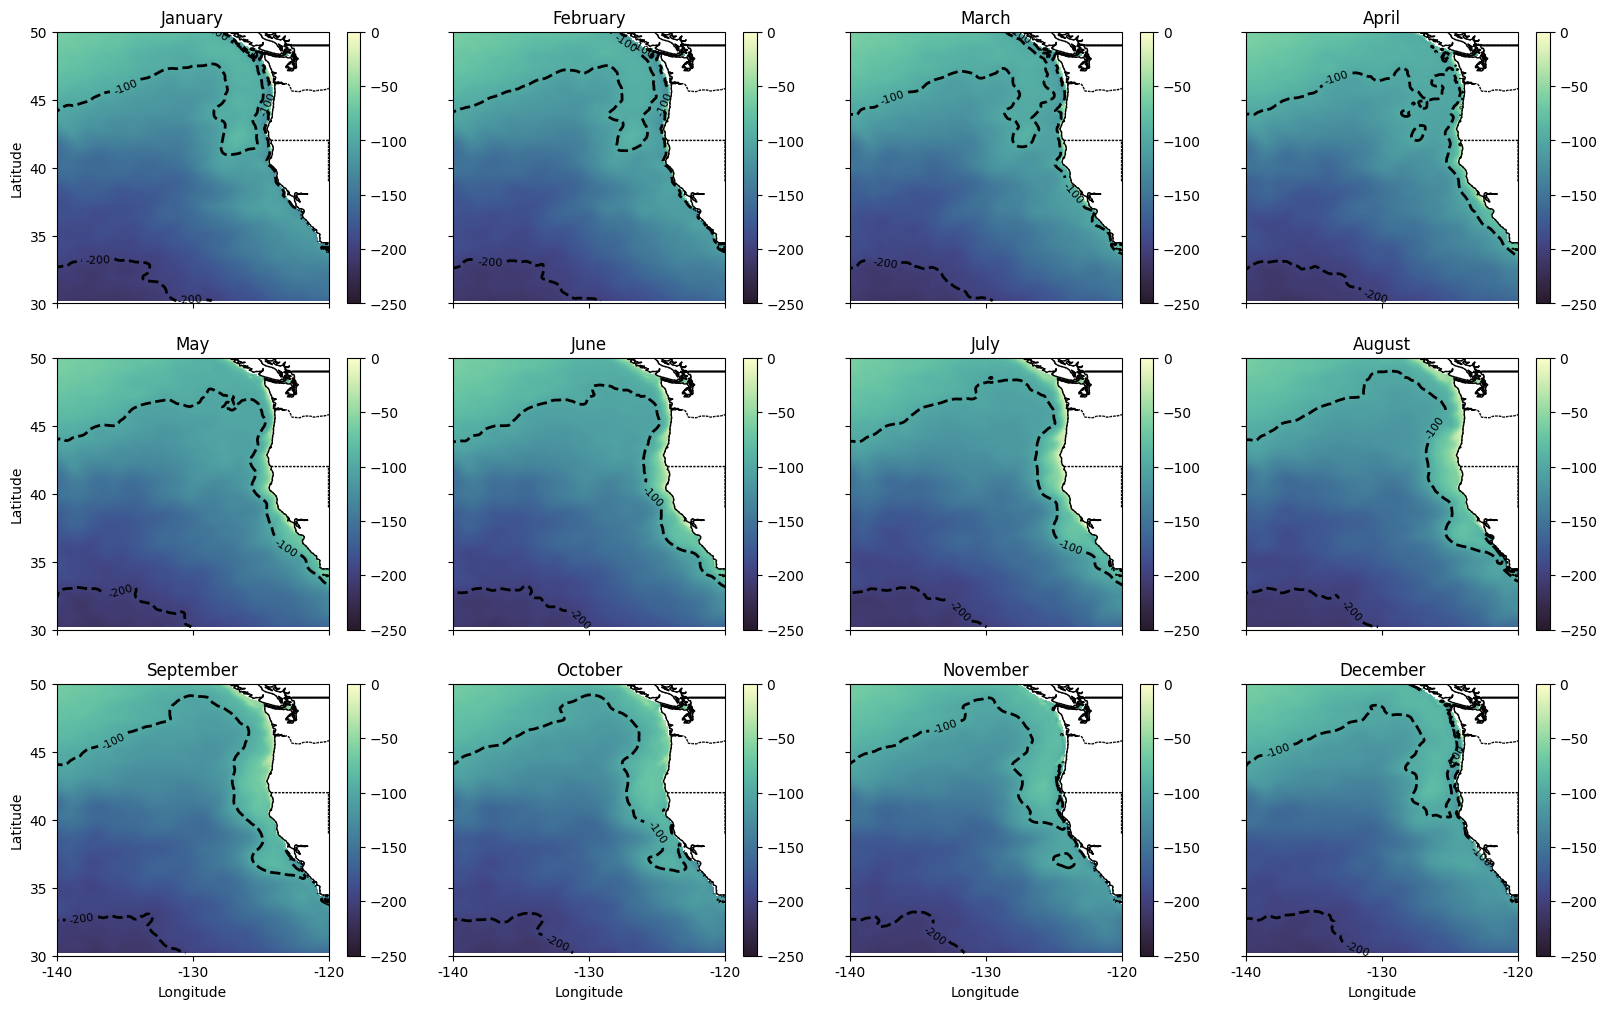

In [5]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        monthly_mean_25_8["lon"],
        monthly_mean_25_8["lat"],
        monthly_mean_25_8["depth"].sel(month=month),
        shading="auto",
        vmin=-250,
        vmax=0,
        cmap=cmo.deep_r,  # pyright: ignore[reportAttributeAccessIssue] # ty: ignore[unresolved-attribute]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        monthly_mean_25_8["lon"],
        monthly_mean_25_8["lat"],
        monthly_mean_25_8["depth"].sel(month=month),
        levels=[-200, -100, 0],
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")
plt.savefig("../misc/oceanic_pathway_isopycnal_depth_25.8.png", dpi=600, bbox_inches="tight")

## Monthly means mixed layer depth

In [6]:
THRESHOLD_SIGMA_0 = 0.1
mld = xr.open_zarr(PARENT_PATH + f"/mixed_layer_depth_delta_sigma_{THRESHOLD_SIGMA_0}.zarr").squeeze()

In [7]:
mld_monthly_mean = mld.groupby("time.month").mean("time")
mld_monthly_mean.compute()
mld_monthly_mean = grid_variable(mld_monthly_mean, "depth")

100%|██████████| 12/12 [00:00<00:00, 111.44it/s]


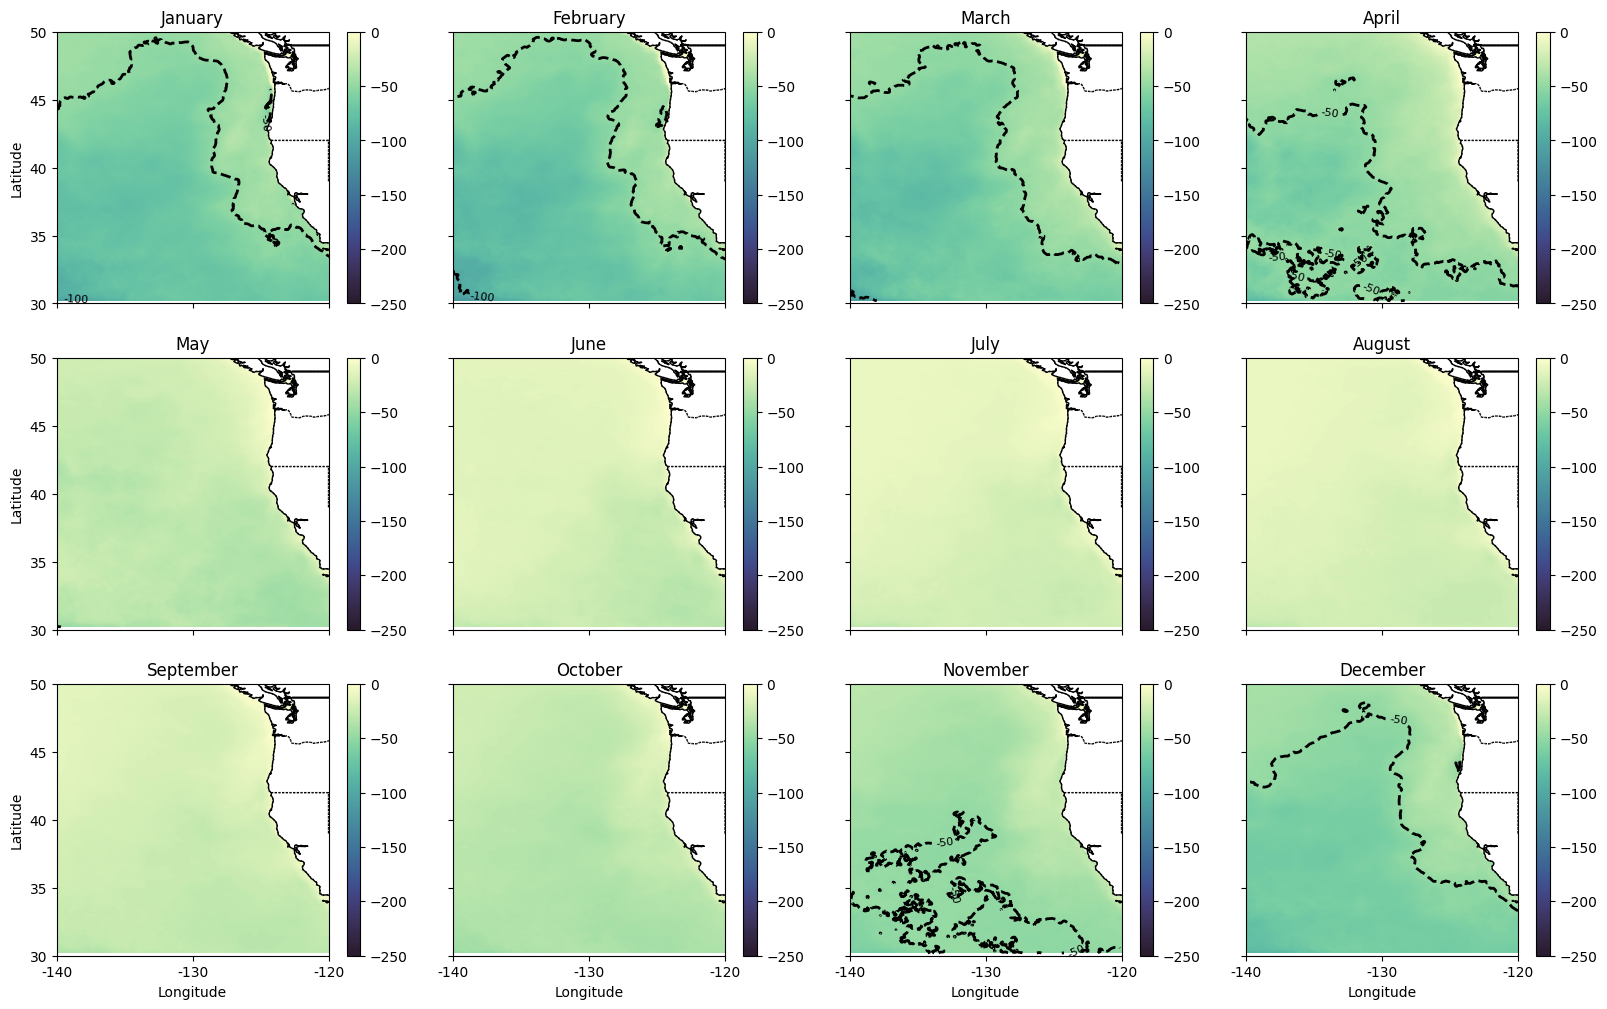

In [8]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        shading="auto",
        vmin=-250,
        vmax=0,
        cmap=cmo.deep_r,  # pyright: ignore[reportAttributeAccessIssue] # ty: ignore[unresolved-attribute]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        levels=[-100, -50, 0],
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_mixed_layer_depth_same_cbar_as_25.8.png", dpi=600, bbox_inches="tight")

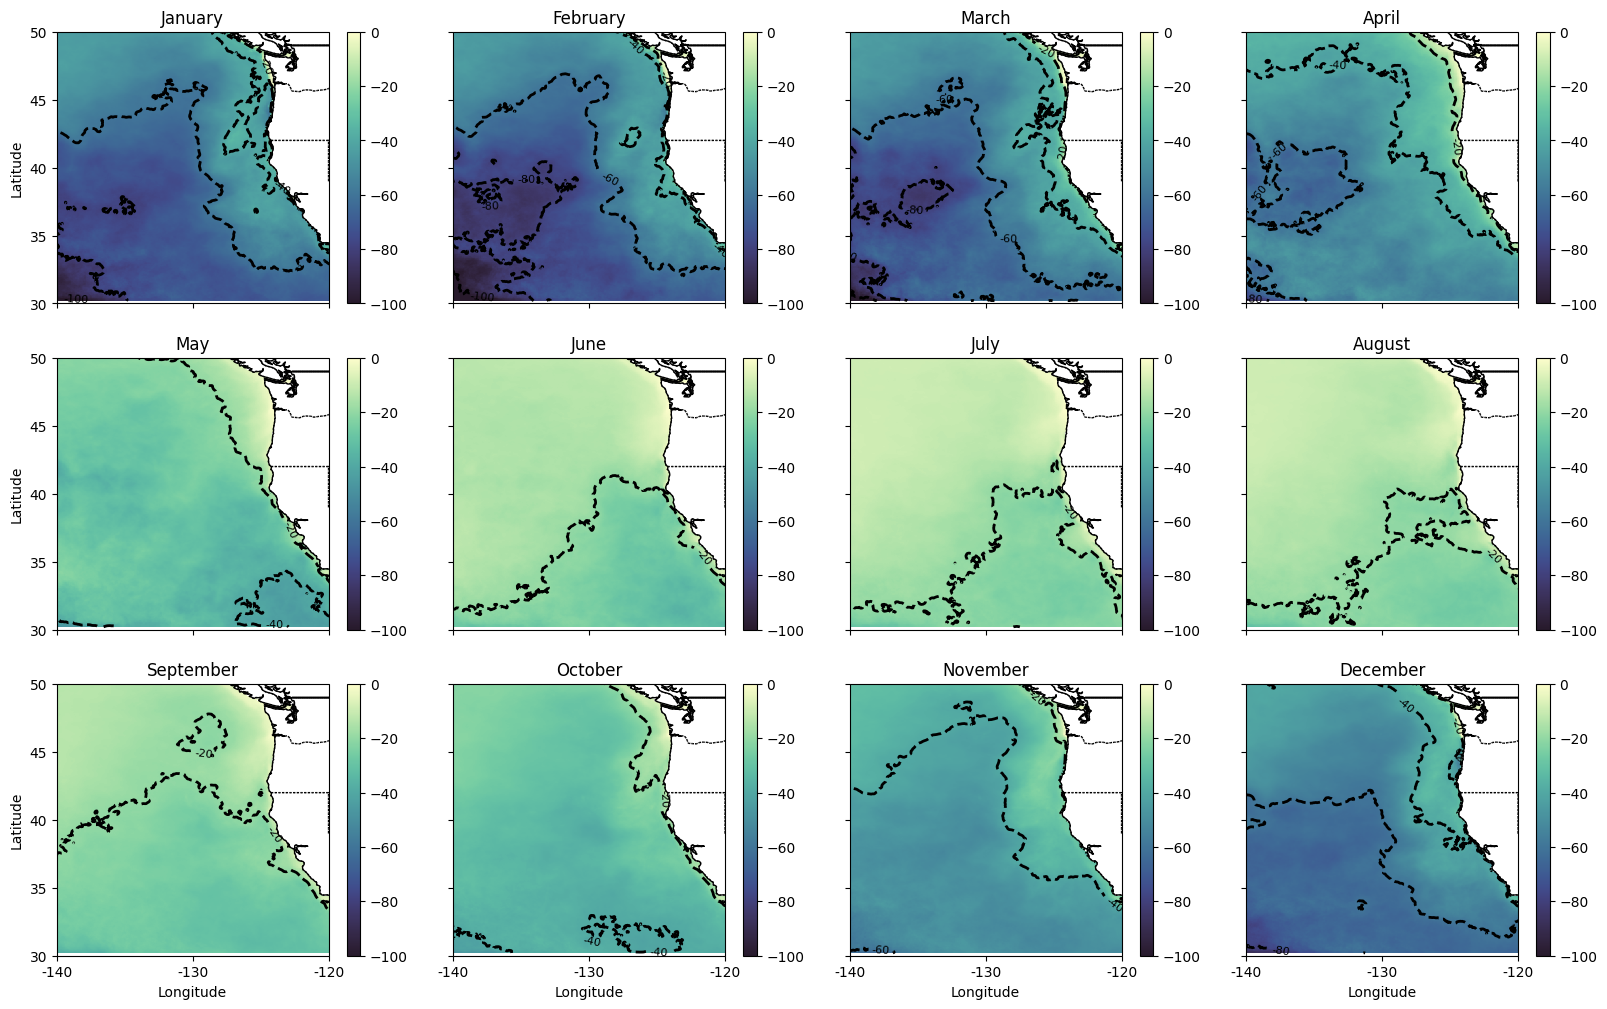

In [9]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        shading="auto",
        vmin=-100,
        vmax=0,
        cmap=cmo.deep_r,  # pyright: ignore[reportAttributeAccessIssue] # ty: ignore[unresolved-attribute]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month),
        levels=np.arange(-100, 1, 20),
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_mixed_layer_depth.png", dpi=600, bbox_inches="tight")

## Difference between 25.8 sigma isopycnal surface depth and mixed layer depth

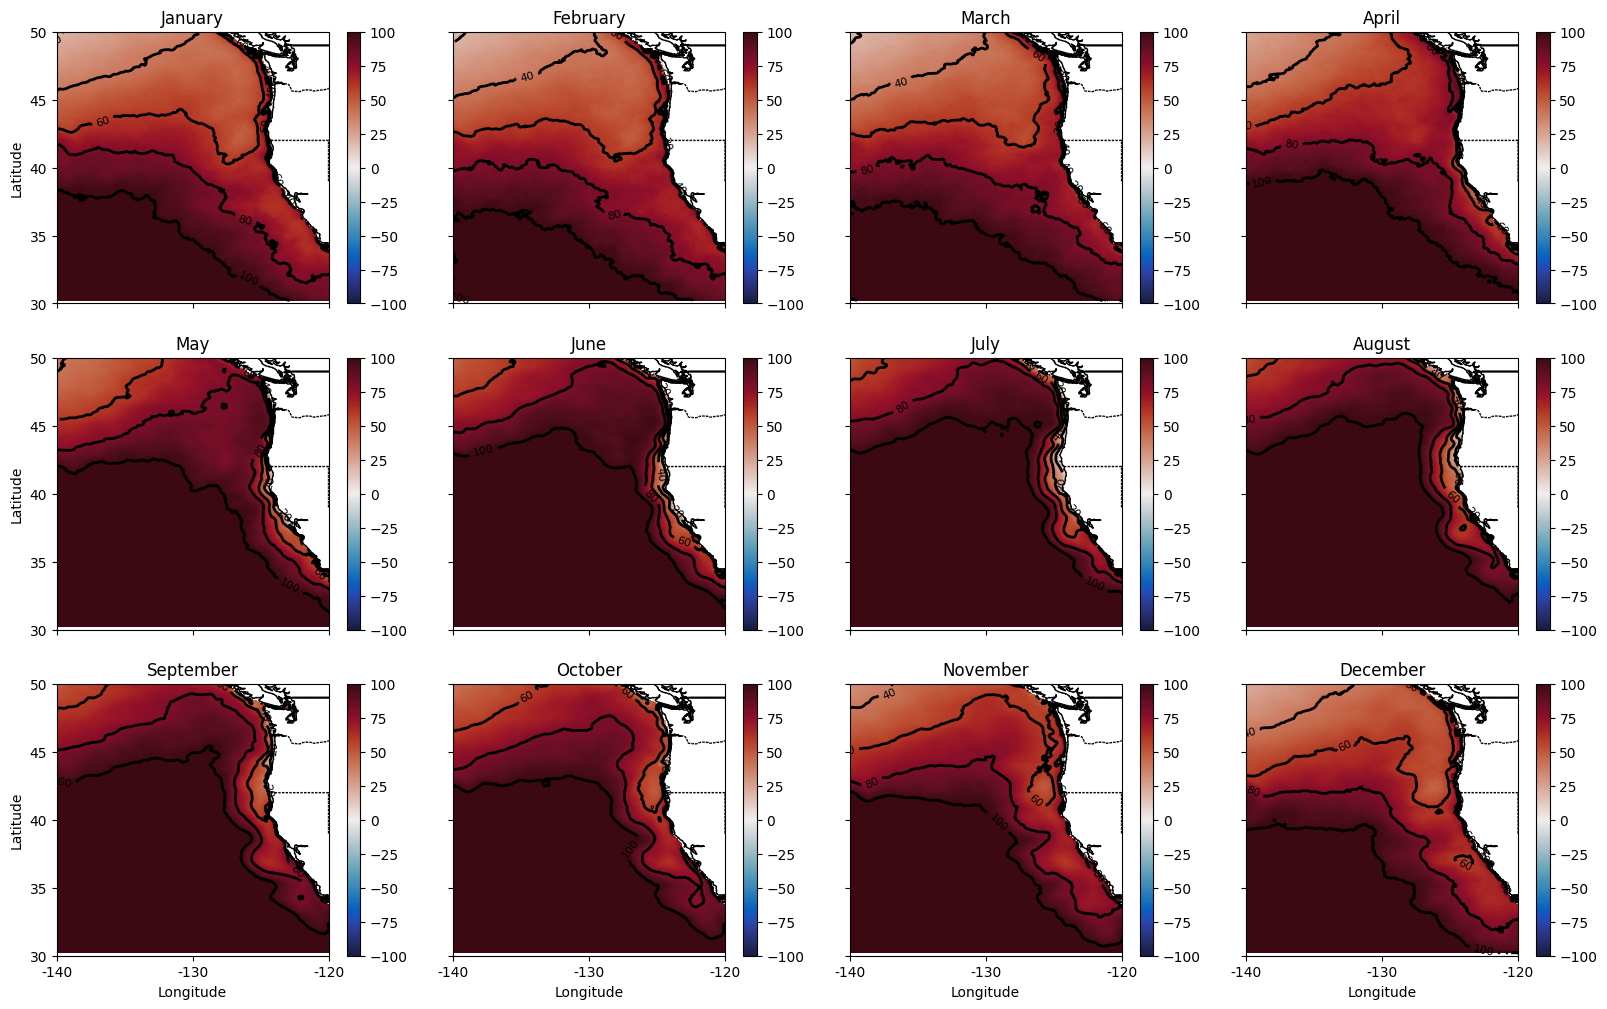

In [10]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month) - monthly_mean_25_8["depth"].sel(month=month),
        shading="auto",
        vmin=-100,
        vmax=100,
        cmap=cmo.balance,  # pyright: ignore[reportAttributeAccessIssue] # ty: ignore[unresolved-attribute]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        mld_monthly_mean["lon"],
        mld_monthly_mean["lat"],
        mld_monthly_mean["depth"].sel(month=month) - monthly_mean_25_8["depth"].sel(month=month),
        levels=np.arange(-100, 101, 20),
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%d")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_25.8_isopycnal_mld_diff.png", dpi=600, bbox_inches="tight")

## Monthly mean density at mixed layer depth

In [11]:
density_at_mld = xr.open_zarr(PARENT_PATH + f"/density_at_mld_delta_sigma_{THRESHOLD_SIGMA_0}.zarr").squeeze()

In [12]:
monthly_mean_density_at_mld = density_at_mld.groupby("time.month").mean("time")
monthly_mean_density_at_mld.compute()
monthly_mean_density_at_mld = grid_variable(monthly_mean_density_at_mld, "density")

100%|██████████| 12/12 [00:00<00:00, 123.88it/s]


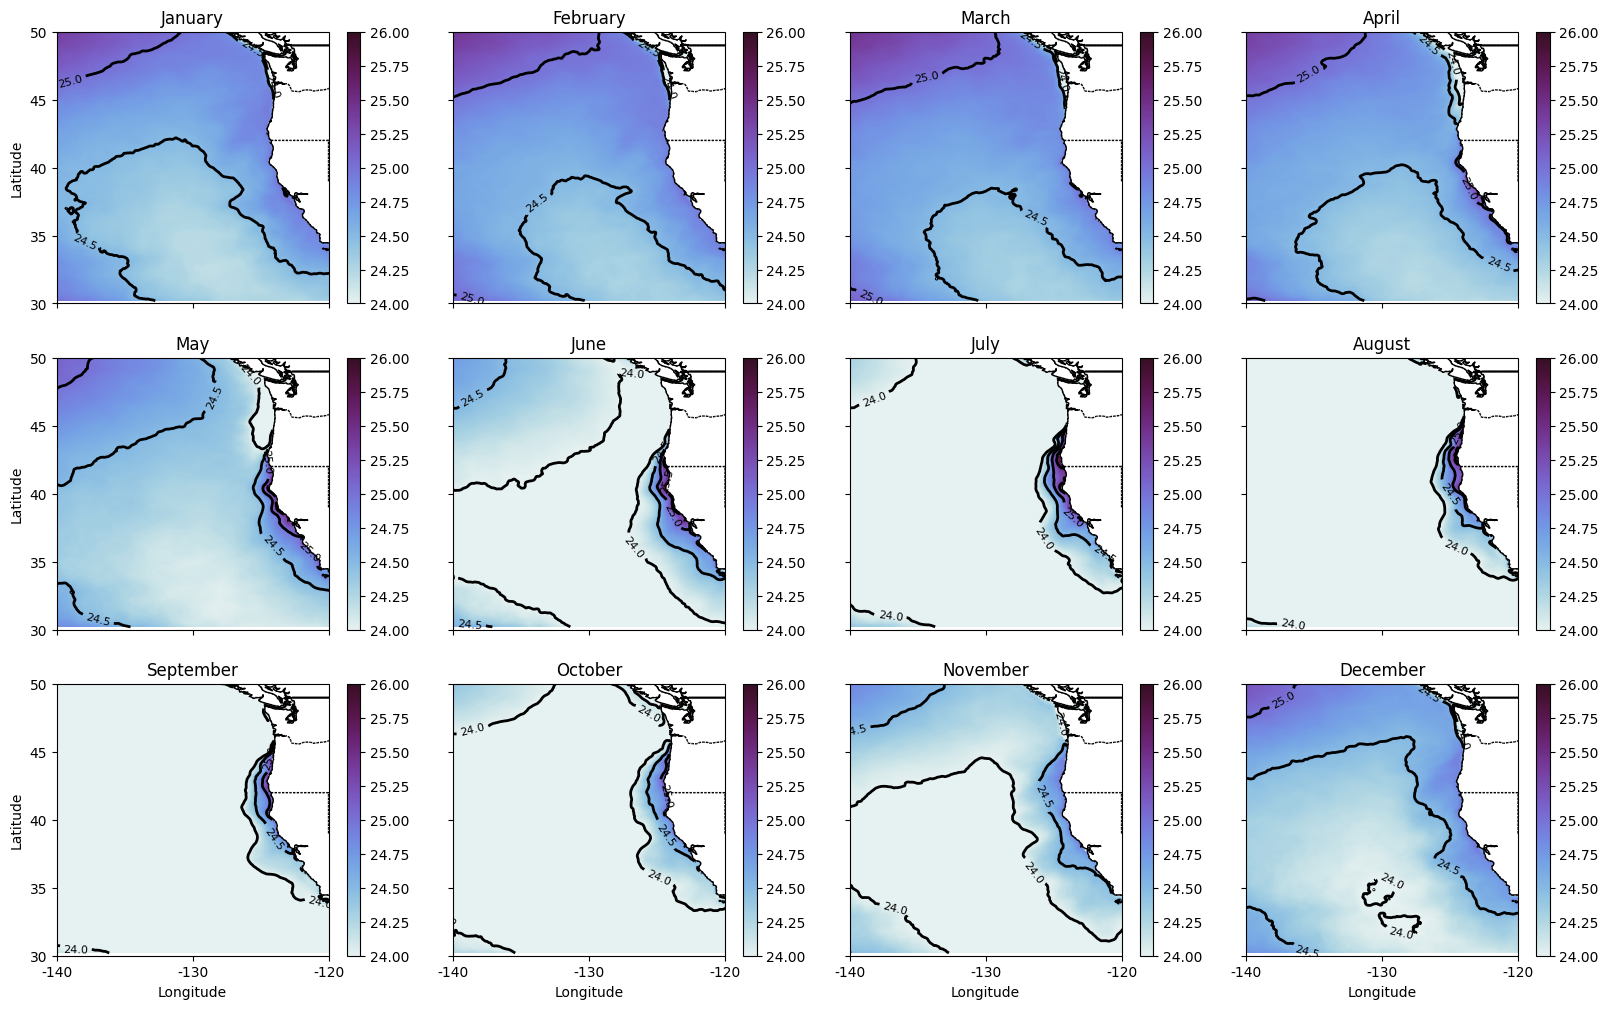

In [13]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        monthly_mean_density_at_mld["lon"],
        monthly_mean_density_at_mld["lat"],
        monthly_mean_density_at_mld["density"].sel(month=month),
        shading="auto",
        vmin=24,
        vmax=26,
        cmap=cmo.dense,  # pyright: ignore[reportAttributeAccessIssue] # ty: ignore[unresolved-attribute]
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    cs = ax.contour(
        monthly_mean_density_at_mld["lon"],
        monthly_mean_density_at_mld["lat"],
        monthly_mean_density_at_mld["density"].sel(month=month),
        levels=np.arange(24, 27, 0.5),
        colors="k",
        linewidths=2,
        transform=ccrs.PlateCarree(),
    )

    plt.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.savefig("../misc/oceanic_pathway_density_at_mld.png", dpi=600, bbox_inches="tight")